1. Вспомним прошлый вебинар, мы рассматривали User-User рекомендации и Item-Item рекомендации. Чем они отличаются и чем они похожи? 

Если есть функция item_item_rec(interaction_matrix). Можно ли использовать эту функцию для user_user_rec?  

В чем принципиальные отличия item-item рекомендаций от ALS?

1.1 Item-Item рекомендации ищут похожие товары, User-User рекомендации ищут похожих пользователей. Похожи тем, что эти оба подхода делают рекомендацию пользователям

1.2 Да можно, если транспонировать user-item матрицу

1.3 ALS это только способ оптимизации

***

2. Приведите 3 примера весов (те, которых не было на вебинаре: сумма покупок, количество покупок - неинтересно) user-item матрицы для задачи рекомендаций товаров 


1) Частота покупок товара за период времени;

2) Размер скидки на товар при его покупке;

3) Повторная покупка или нет

***

3. Какие ограничения есть у ALS? (Тип информации, линейность/нелинейность факторов и т д)


Не нашёл вообще никакой информации об ограничениях непосредственно данного алгоритма. Везде рассматриваются только его преимущества.

Возможно что ограничения данного алгоритма соответствуют ограничениям непосредственно самой матричной факторизации.
То есть не допускается наличие нулевых строк/столбцов (новых пользователей/товаров без истории взаимодействия)

***

4. Мы рассматривали bm_25_weight. 
Опишите, как он работает. Как сделать рекомендации только на основе bm_25? (Можно и нужно пользоваться любыми источниками, приложите на них ссылки). Какие еще способы перевзвешивания user-item матрицы Вы знаете / можете предложить (ещё 2-3 способа)?

BM25 это модификация TF-IDF взвешивания.

Если по аналогии с NLP user-item матрицу принять за коллекцию, строку user/столбец item за документ, а interaction за слово, то данная функция вычисляет вес пропорционально частоте употребления этого слова в документе и обратно пропорционален частоте употребления слова во всех документах коллекции.

Чтобы сделать рекомендации на основе bm25 необходимо полученную в результате перевзвешивания матрицу передать в качестве весов в выбранную модель.

Можно, перевзвешивать матрицу на основе схожести пользователей (например, взять матрицу схожести интересов и матрицу схожести проставленных рейтингов и вычислить их среднее занчение [https://pdfs.semanticscholar.org/ccdc/a6314ea0f87d3537862d63c541d3d1a676d4.pdf])

***

### Подбор матрицы $c_{ui}$
Попробуйте различные варианты матрицы весов (3+ вариантов). Обучите алгоритм для различных $C$. В качестве результата приведите таблицу: матрица весов - результат на train и validation.
Сделате качественные выводы.


In [26]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns

from scipy.sparse import csr_matrix, coo_matrix

import implicit

from implicit.nearest_neighbours import bm25_weight, tfidf_weight

from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

In [2]:
def precis_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

In [3]:
df = pd.read_csv('retail_train.csv')
df.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
test_size_week = 3
df_train = df[df['week_no'] < df['week_no'].max() - test_size_week]
df_test = df[df['week_no'] >= df['week_no'].max() - test_size_week]

In [5]:
result = df_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result['actual'] = result['actual'].apply(lambda x: list(x))

In [6]:
popularity = df_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

df_train.loc[~df_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(df_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1
user_item_matrix = user_item_matrix.astype(float)

sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(2)

/home/creep/anaconda3/envs/gb_study/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [8]:
bm25_matrix = bm25_weight(user_item_matrix.T).T 
tfidf_matrix = tfidf_weight(user_item_matrix.T).T

In [9]:
%%time

model_als_base = AlternatingLeastSquares()

model_als_base.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_base'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model_als_base.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=True)])


CPU times: user 1min 16s, sys: 1.01 s, total: 1min 17s
Wall time: 20.5 s


In [10]:
%%time

model_als_bm25 = AlternatingLeastSquares()

model_als_bm25.fit(csr_matrix(bm25_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_bm25'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model_als_bm25.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=True)])


CPU times: user 1min 12s, sys: 1.31 s, total: 1min 14s
Wall time: 22.2 s


In [11]:
%%time

model_asl_tfidf = AlternatingLeastSquares()

model_asl_tfidf.fit(csr_matrix(tfidf_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_tfidf'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model_asl_tfidf.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=True)])


CPU times: user 1min 12s, sys: 985 ms, total: 1min 13s
Wall time: 20.2 s


In [12]:
result['precision@5_tfidf_recs'] = \
result[['als_tfidf','actual']].apply(lambda x: precis_at_k(*x), axis=1)

result['precision@5_als_recs'] = \
result[['als_base','actual']].apply(lambda x: precis_at_k(*x), axis=1)

result['precision@5_bm25_recs'] = \
result[['als_bm25','actual']].apply(lambda x: precis_at_k(*x), axis=1)

In [13]:
result.head(2)

,user_id,actual,als_base,als_bm25,als_tfidf,precision@5_tfidf_recs,precision@5_als_recs,precision@5_bm25_recs
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[995242, 1033142, 979707, 1082185, 962568]","[1082185, 1135694, 1046816, 911409, 871570]","[1033142, 1082185, 1005186, 1056509, 995242]",0.6,0.8,0.2
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1133018, 1106523, 910032, 5568378, 9337581]","[951590, 826249, 883404, 1044078, 1053690]","[951590, 910032, 1106523, 1133018, 1044078]",0.0,0.0,0.2


In [14]:
mp5_als_recs = result['precision@5_als_recs'].mean()
mp5_tfidf_recs = result['precision@5_tfidf_recs'].mean()
mp5_bm25_recs = result['precision@5_bm25_recs'].mean()

In [15]:
metrics_dict = {}
metrics_dict['ALS_Base'] = mp5_als_recs * 100
metrics_dict['ALS_TF-IDF'] = mp5_tfidf_recs * 100
metrics_dict['ALS_BM25'] = mp5_bm25_recs * 100
pd.DataFrame(list(metrics_dict.items()),
             columns=['Метод', 'Значение, %']).sort_values(by=['Значение, %'], ascending=False)

,Метод,"Значение, %"
1,ALS_TF-IDF,21.527914
0,ALS_Base,20.979432
2,ALS_BM25,19.353575


Даже с помощью общих методов перевзвешивания можно добиться улучшения бейзлайна модели. Если правильно подобрать индивидуальную матрицу весов под конкретную задачу, то можно ещё сильнее улучшить результат.

Удивило что BM25 оказался хуже TF-IDF, хотя это улучшенная версия TF-IDF.

***

### Оптимизация гипперпараметров
Для лучшей матрицы весов из первого задания подберите оптимальные $\lambda$ и n_factors. Подбор можно делать вручную (цикл в цикле, аналог sklearn.GridSearch, или случайно - sklearn.GridSearch). Или Вы можете воспользоваться библиотеками для автоматического подбора гипперпараметров (любые на Ваш вкус). В качестве результата постройте графики:
1. Значение параметра - время обучения 
2. Значение параметра - качество train, качество validation  

Сделайте качественные выводы

**P.S.** Не пишите отписки в качестве выводов. Мне интресены Ваши рассуждения, трудности, с которыми Вы сталкнулись и что-то, что Вас удивило. Если выводы контринтуитивны - напишите об этом, в этом нет ничего страшного!

In [16]:
import time
def exec_time(start, end):
    diff_time = end - start
    return diff_time

In [17]:
factors = [1, 10, 20, 50, 100, 200, 500, 1000]
regularisation_coefs = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

In [18]:
%%time
statistic_dict = {}
for factor in factors:
    for reg_coef in regularisation_coefs:
        start = time.time()
        model_asl_tfidf = AlternatingLeastSquares(factors=factor,
                                                  regularization=reg_coef)
        model_asl_tfidf.fit(csr_matrix(tfidf_matrix).T.tocsr(),
          show_progress=False)

        result[f'als_tfidf_factors{factor}_regularization{reg_coef}'] = result['user_id'].\
            apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                            model_asl_tfidf.recommend(userid=userid_to_id[x], 
                                            user_items=sparse_user_item,
                                            N=5, 
                                            filter_already_liked_items=False, 
                                            filter_items=[itemid_to_id[999999]], 
                                            recalculate_user=True)])
        end = time.time()
        check_time = exec_time(start, end)
        result[f'precision@5_als_tfidf_factors{factor}_regularization{reg_coef}_recs'] = \
        result[[f'als_tfidf_factors{factor}_regularization{reg_coef}', \
                'actual']].apply(lambda x: precis_at_k(*x), axis=1)
        cur_prec = result[f'precision@5_als_tfidf_factors{factor}_regularization{reg_coef}_recs'].mean() * 100
        statistic_dict[f'precision@5_als_tfidf_factors{factor}_regularization{reg_coef}_recs'] = \
        (check_time, cur_prec, factor, reg_coef)

CPU times: user 5h 4min 40s, sys: 4min 31s, total: 5h 9min 12s
Wall time: 1h 53min 35s


In [19]:
result_df = pd.DataFrame(list(statistic_dict.items()),
             columns=['Параметры', 'Значения'])

In [20]:
result_df = result_df['Значения'].apply((pd.Series))

In [21]:
result_df.rename(columns={0: 'time, sec', 1: 'precision@5', 2: 'factors', 3: 'regularization coeff'}, inplace=True)

In [22]:
result_df.head(2)

,"time, sec",precision@5,factors,regularization coeff
0,7.213375,19.285015,1.0,0.001
1,7.333795,19.285015,1.0,0.005


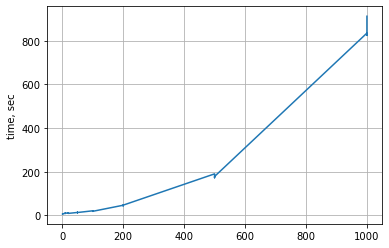

In [23]:
plt.plot(result_df['factors'], result_df['time, sec'])
plt.ylabel('time, sec')
plt.grid()
plt.show()

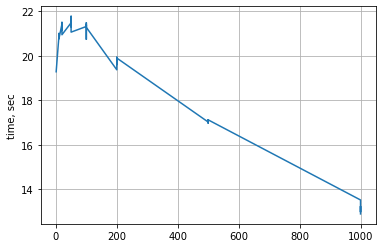

In [24]:
plt.plot(result_df['factors'], result_df['precision@5'])
plt.ylabel('time, sec')
plt.grid()
plt.show()

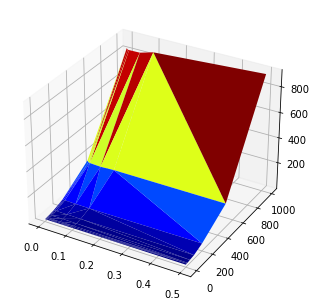

In [27]:

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_trisurf(result_df['regularization coeff'],
                result_df['factors'],
                result_df['time, sec'],
                cmap=cm.jet,
                linewidth=0.2)
plt.show()

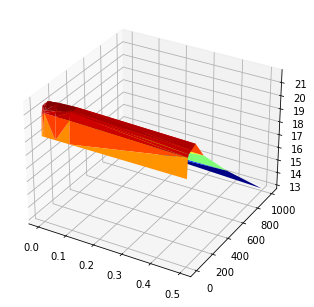

In [28]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_trisurf(result_df['regularization coeff'],
                result_df['factors'],
                result_df['precision@5'],
                cmap=cm.jet,
                linewidth=0.2)
plt.show()

К подбору гиперпараметров также как и в любой другой модели необходимо подходить с умом.

Как видно из графиков завимость времени выполнения от значения factors значительно увеличивается, при это точность растёт только до определённого момента, после чего начинает резко падать.

В нашей задаче коэффициент регуляризации практически не влияет ни на время, ни на точность.